In [1]:
# !git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/pytorch-CycleGAN-and-pix2pix-master/

/content/drive/.shortcut-targets-by-id/1P18iRI7zAiw3dOnyBYVu2wRITqd752uG/pytorch-CycleGAN-and-pix2pix-master


In [3]:
!pwd
%matplotlib inline

/content/drive/.shortcut-targets-by-id/1P18iRI7zAiw3dOnyBYVu2wRITqd752uG/pytorch-CycleGAN-and-pix2pix-master


In [4]:
# http://vis-www.cs.umass.edu/lfw/ datast was taken from here
import argparse
import os
from util import util
import torch
import models
import data


import time

from data import create_dataset
from models import create_model
import matplotlib.pyplot as plt
 

def_list=["--dataroot","./datasets/faces/","--name" ,"faces_pix2pix","--direction", "AtoB",'--model','pix2pix']

class BaseOptions():
    """This class defines options used during both training and test time.

    It also implements several helper functions such as parsing, printing, and saving the options.
    It also gathers additional options defined in <modify_commandline_options> functions in both dataset class and model class.
    """

    def __init__(self):
        """Reset the class; indicates the class hasn't been initailized"""
        self.initialized = False

    def initialize(self, parser):
        """Define the common options that are used in both training and test."""
        # basic parameters
        parser.add_argument('--dataroot',  required=False, help='path to images (should have subfolders trainA, trainB, valA, valB, etc)')
        parser.add_argument('--name', type=str, default='experiment_name', help='name of the experiment. It decides where to store samples and models')
        parser.add_argument('--use_wandb', action='store_true', help='use wandb')
        parser.add_argument('--gpu_ids', type=str, default='0', help='gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
        parser.add_argument('--checkpoints_dir', type=str, default='./checkpoints', help='models are saved here')
        # model parameters
        parser.add_argument('--model', type=str, default='cycle_gan', help='chooses which model to use. [cycle_gan | pix2pix | test | colorization]')
        parser.add_argument('--input_nc', type=int, default=3, help='# of input image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--output_nc', type=int, default=3, help='# of output image channels: 3 for RGB and 1 for grayscale')
        parser.add_argument('--ngf', type=int, default=32, help='# of gen filters in the last conv layer')
        parser.add_argument('--ndf', type=int, default=32, help='# of discrim filters in the first conv layer')
        parser.add_argument('--netD', type=str, default='basic', help='specify discriminator architecture [basic | n_layers | pixel]. The basic model is a 70x70 PatchGAN. n_layers allows you to specify the layers in the discriminator')
        parser.add_argument('--netG', type=str, default='resnet_9blocks', help='specify generator architecture [resnet_9blocks | resnet_6blocks | unet_256 | unet_128]')
        parser.add_argument('--n_layers_D', type=int, default=3, help='only used if netD==n_layers')
        parser.add_argument('--norm', type=str, default='instance', help='instance normalization or batch normalization [instance | batch | none]')
        parser.add_argument('--init_type', type=str, default='normal', help='network initialization [normal | xavier | kaiming | orthogonal]')
        parser.add_argument('--init_gain', type=float, default=0.02, help='scaling factor for normal, xavier and orthogonal.')
        parser.add_argument('--no_dropout', action='store_true', help='no dropout for the generator')
        # dataset parameters
        parser.add_argument('--dataset_mode', type=str, default='unaligned', help='chooses how datasets are loaded. [unaligned | aligned | single | colorization]')
        parser.add_argument('--direction', type=str, default='AtoB', help='AtoB or BtoA')
        parser.add_argument('--serial_batches', action='store_true', help='if true, takes images in order to make batches, otherwise takes them randomly')
        parser.add_argument('--num_threads', default=4, type=int, help='# threads for loading data')
        parser.add_argument('--batch_size', type=int, default=1, help='input batch size')
        parser.add_argument('--load_size', type=int, default=286, help='scale images to this size')
        parser.add_argument('--crop_size', type=int, default=256, help='then crop to this size')
        parser.add_argument('--max_dataset_size', type=int, default=float("inf"), help='Maximum number of samples allowed per dataset. If the dataset directory contains more than max_dataset_size, only a subset is loaded.')
        parser.add_argument('--preprocess', type=str, default='resize_and_crop', help='scaling and cropping of images at load time [resize_and_crop | crop | scale_width | scale_width_and_crop | none]')
        parser.add_argument('--no_flip', action='store_true', help='if specified, do not flip the images for data augmentation')
        parser.add_argument('--display_winsize', type=int, default=256, help='display window size for both visdom and HTML')
        # additional parameters
        parser.add_argument('--epoch', type=str, default='latest', help='which epoch to load? set to latest to use latest cached model')
        parser.add_argument('--load_iter', type=int, default='0', help='which iteration to load? if load_iter > 0, the code will load models by iter_[load_iter]; otherwise, the code will load models by [epoch]')
        parser.add_argument('--verbose', action='store_true', help='if specified, print more debugging information')
        parser.add_argument('--suffix', default='', type=str, help='customized suffix: opt.name = opt.name + suffix: e.g., {model}_{netG}_size{load_size}')
        self.initialized = True   
        return parser    

    def gather_options(self):

        """
        Initialize our parser with basic options(only once).
        Add additional model-specific and dataset-specific options.
        These options are defined in the <modify_commandline_options> function
        in model and dataset classes.

        """

        if not self.initialized:  # check if it has been initialized
            parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
            parser = self.initialize(parser)

        # get the basic options
        opt, _ = parser.parse_known_args(def_list)

        # modify model-related parser options
        model_name = opt.model
        model_option_setter = models.get_option_setter(model_name)
        parser = model_option_setter(parser, self.isTrain)
        opt, _ = parser.parse_known_args(def_list)  # parse again with new defaults

        # modify dataset-related parser options
        dataset_name = opt.dataset_mode
        dataset_option_setter = data.get_option_setter(dataset_name)
        parser = dataset_option_setter(parser, self.isTrain)

        # save and return the parser
        self.parser = parser
        return parser.parse_args(def_list)

    def print_options(self, opt):
        """Print and save options

        It will print both current options and default values(if different).
        It will save options into a text file / [checkpoints_dir] / opt.txt
        """
        message = ''
        message += '----------------- Options ---------------\n'
        for k, v in sorted(vars(opt).items()):
            comment = ''
            default = self.parser.get_default(k)
            if v != default:
                comment = '\t[default: %s]' % str(default)
            message += '{:>25}: {:<30}{}\n'.format(str(k), str(v), comment)
        message += '----------------- End -------------------'
        print(message)

        # save to the disk
        expr_dir = os.path.join(opt.checkpoints_dir, opt.name)
        util.mkdirs(expr_dir)
        file_name = os.path.join(expr_dir, '{}_opt.txt'.format(opt.phase))
        with open(file_name, 'wt') as opt_file:
            opt_file.write(message)
            opt_file.write('\n')

    def parse(self):
        """Parse our options, create checkpoints directory suffix, and set up gpu device."""
        opt = self.gather_options()
        opt.isTrain = self.isTrain   # train or test

        # process opt.suffix
        if opt.suffix:
            suffix = ('_' + opt.suffix.format(**vars(opt))) if opt.suffix != '' else ''
            opt.name = opt.name + suffix

        self.print_options(opt)

        # set gpu ids
        str_ids = opt.gpu_ids.split(',')
        opt.gpu_ids = []
        for str_id in str_ids:
            id = int(str_id)
            if id >= 0:
                opt.gpu_ids.append(id)
        if len(opt.gpu_ids) > 0:
            torch.cuda.set_device(opt.gpu_ids[0])

        self.opt = opt
        return self.opt




#from util.visualizer import Visualizer

# if __name__ == '__main__':



class TestOptions(BaseOptions):
    """This class includes test options.

    It also includes shared options defined in BaseOptions.
    """

    def initialize(self, parser):
        parser = BaseOptions.initialize(self, parser)  # define shared options
        parser.add_argument('--results_dir', type=str, default='./imgs/', help='saves results here.')
        parser.add_argument('--aspect_ratio', type=float, default=1.0, help='aspect ratio of result images')
        parser.add_argument('--phase', type=str, default='test', help='train, val, test, etc')
        # Dropout and Batchnorm has different behavioir during training and test.
        parser.add_argument('--eval', action='store_true', help='use eval mode during test time.')
        parser.add_argument('--num_test', type=int, default=50, help='how many test images to run')
        # rewrite devalue values
        parser.set_defaults(model='test')
        # To avoid cropping, the load_size should be the same as crop_size
        parser.set_defaults(load_size=parser.get_default('crop_size'))
        self.isTrain = False
        return parser



opt = TestOptions().parse()  # get test options


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets/faces/             	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                            

In [5]:

# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 0
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
dataset_size = len(dataset)    # get the number of images in the dataset.
print('The number of training images = %d' % dataset_size)

model = create_model(opt)      # create a model given opt.model and other options
# model.setup(opt)               # regular setup: load and print networks; create schedulers



dataset [AlignedDataset] was created
The number of training images = 2
initialize network with normal
model [Pix2PixModel] was created


In [6]:
model.setup(opt)


loading the model from ./checkpoints/faces_pix2pix/latest_net_G.pth
<bound method BaseModel.load_networks of <models.pix2pix_model.Pix2PixModel object at 0x7f980f7ecc90>>
---------- Networks initialized -------------
[Network G] Total number of parameters : 13.608 M
-----------------------------------------------


In [7]:

if opt.eval:
    model.eval()
original=[]
cartoon=[]
for i, data in enumerate(dataset):
    if i >= opt.num_test:  # only apply our model to opt.num_test images.
        break
    model.set_input(data)  # unpack data from data loader
    model.test()           # run inference
    visuals = model.get_current_visuals()  # get image results
    original.append(model.real_A)
    cartoon.append(model.fake_B)
    img_path = model.get_image_paths()     # get image paths


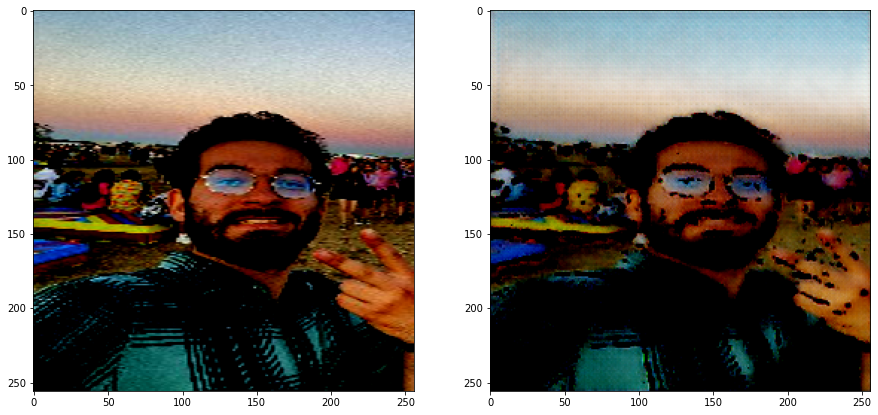

In [8]:


i=1

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)

plt.imshow(original[i].squeeze().permute(1,2,0).cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(cartoon[i].squeeze().permute(1,2,0).cpu().numpy())


